In [8]:
### import required libraries and pkgs ###
import glob
import os
import librosa
import numpy as np
#from sklearn.model_selection import KFold
#from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
#import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import *
from keras.utils import *
from keras.initializers import *
import tensorflow as tf

In [2]:
#new features

def Myextract_features(filePath, sampleRate=44100):
    
    signal,sr = librosa.load(filePath, sampleRate)

    centroid = librosa.feature.spectral_centroid(y=signal,sr=sr)
    #mfcc = librosa.feature.mfcc(y=signal, sr=sr)
    #features = librosa.feature.melspectrogram(y=signal,sr=sr, n_mels=1)
    slope = librosa.feature.melspectrogram(y=signal, sr=sr)

    #features = np.concatenate((mel,mfcc),axis=0)
    features = np.concatenate((centroid,slope),axis=0)
    
    return features

In [4]:
import pandas as pd

filenames = pd.read_csv('/Users/pooyan/Documents/CMMS/normal.csv')
#convert filenames from dataframe to array
filenames = np.array(filenames['name'].values)
#read all noraml files
parent_dir = '/Users/pooyan/Desktop/data_cmms/skytraina_06252019/turbo/'
sub_dir = 'combine/'
file_ext='*.ogg'
#all_Normalfiles = glob.glob(os.path.join(parent_dir, sub_dir, file_ext))[0:2500]
all_Normalfiles = parent_dir +sub_dir+ filenames


all_noraml_features = [] #define an empty array
all_noraml_labels = []
for i in range(0,len(all_Normalfiles)):
    my_features = Myextract_features(all_Normalfiles[i])
    all_noraml_features.append(my_features)
    all_noraml_labels.append("normal")

#use reshape to conver outputs into arrays
dim_1 = len(all_Normalfiles)
dim_2 = my_features.shape[0] #number of features
dim_3 = my_features.shape[1]
all_noraml_features = np.asarray(all_noraml_features).reshape(dim_1, dim_2, dim_3)
all_noraml_labels = np.asarray(all_noraml_labels).reshape(dim_1)

#check the dimentions
print(all_noraml_features.shape)
print(all_noraml_labels.shape)

#read all anoamly files
filenames = pd.read_csv('/Users/pooyan/Documents/CMMS/anomaly.csv')
#convert filenames from dataframe to array
filenames = np.array(filenames['name'].values)

parent_dir = '/Users/pooyan/Desktop/data_cmms/skytraina_06252019/turbo/'
sub_dir = 'combine/'
file_ext='*.ogg'
#all_Anomalyfiles = glob.glob(os.path.join(parent_dir, sub_dir, file_ext))[0:1000]
all_Anomalyfiles = parent_dir +sub_dir+ filenames

all_anomaly_features = [] #define an empty array
all_anomaly_labels = []
for i in range(0,len(all_Anomalyfiles)):
    my_features = Myextract_features(all_Anomalyfiles[i])
    all_anomaly_features.append(my_features)
    all_anomaly_labels.append("anomaly")

#use reshape to conver outputs into arrays
dim_1 = len(all_Anomalyfiles)
dim_2 = my_features.shape[0] #number of features
dim_3 = my_features.shape[1]
all_anomaly_features = np.asarray(all_anomaly_features).reshape(dim_1, dim_2, dim_3)
all_anomaly_labels = np.asarray(all_anomaly_labels).reshape(dim_1)

#check the dimentions
print(all_anomaly_features.shape)
print(all_anomaly_labels.shape)

#Merge noraml and anomaly arrays
all_data = np.concatenate((all_noraml_features,all_anomaly_features),axis=0)
all_label = np.concatenate((all_noraml_labels,all_anomaly_labels),axis=0)

#check the dimentions
print(all_data.shape)

(8633, 129, 259)
(8633,)
(2308, 129, 259)
(2308,)
(10941, 129, 259)


In [5]:
#endocding labels
my_ec = LabelEncoder()
all_label = my_ec.fit_transform(all_label)

my_ec.transform(["normal"])
my_ec.inverse_transform(all_label)

#split data into train. validation, and test
X_train, X_test, y_train, y_test = train_test_split(all_data,all_label,test_size=0.2,shuffle=True)
X_train, X_validation, y_train, y_validation = train_test_split(X_train,y_train,test_size=0.2,shuffle=True)

#check the dimentions
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

#check the dimentions
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(7001, 129, 259)
(2189, 129, 259)
(1751, 129, 259)
(7001, 129, 259)
(2189, 129, 259)
(1751, 129, 259)


In [9]:
model = Sequential()
model.add(LSTM(200, return_sequences=True, input_shape=(129,259)))
model.add(Conv1D(200, kernel_size=3, activation = 'relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(Dense(100))
model.add(Dense(2, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 129, 200)          368000    
                                                                 
 conv1d (Conv1D)             (None, 127, 200)          120200    
                                                                 
 global_max_pooling1d (Globa  (None, 200)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 508,502
Trainable params: 508,502
Non-trainable params: 0
__________________________________________________

In [10]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
history=model.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 20, batch_size = 128, verbose = 1)


Epoch 1/20
55/55 [==============================] - 16s 256ms/step - loss: 0.5341 - accuracy: 0.7700 - val_loss: 0.3811 - val_accuracy: 0.8030
Epoch 2/20
55/55 [==============================] - 13s 244ms/step - loss: 0.2774 - accuracy: 0.8813 - val_loss: 0.1781 - val_accuracy: 0.9549
Epoch 3/20
55/55 [==============================] - 13s 240ms/step - loss: 0.1012 - accuracy: 0.9880 - val_loss: 0.0574 - val_accuracy: 0.9931
Epoch 4/20
55/55 [==============================] - 13s 237ms/step - loss: 0.0323 - accuracy: 0.9941 - val_loss: 0.0242 - val_accuracy: 0.9949
Epoch 5/20
55/55 [==============================] - 13s 238ms/step - loss: 0.0179 - accuracy: 0.9947 - val_loss: 0.0218 - val_accuracy: 0.9949
Epoch 6/20
55/55 [==============================] - 14s 258ms/step - loss: 0.0106 - accuracy: 0.9973 - val_loss: 0.0165 - val_accuracy: 0.9954
Epoch 7/20
55/55 [==============================] - 17s 305ms/step - loss: 0.0076 - accuracy: 0.9974 - val_loss: 0.0118 - val_accuracy: 0.9954

In [17]:
#train
from sklearn.metrics import confusion_matrix

pred = model.predict(X_train)
y_pred = [0 if y[0]>.94 else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 0.919297
Precision: 0.907423
Recall: 1.000000
F1 score: 0.951465
Cohens kappa: 0.715464
ROC AUC: 0.806904
[[ 898  565]
 [   0 5538]]


In [12]:
#test
pred = model.predict(X_test)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.995889
Precision: 0.996477
Recall: 0.998235
F1 score: 0.997355
Cohens kappa: 0.988125
ROC AUC: 0.992983
[[ 483    6]
 [   3 1697]]


In [18]:
model = Sequential()
model.add(Conv1D(40, kernel_size=3, activation = 'relu', input_shape=(129,259)))
model.add(LSTM(30, return_sequences=True))
model.add(Conv1D(20, kernel_size=3, activation = 'relu'))
model.add(Dropout(rate=0.2))
model.add(LSTM(100))
model.add(Dropout(rate=0.2))
model.add(Dense(100))
model.add(Dropout(rate=0.2))
model.add(Dense(2, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 127, 40)           31120     
                                                                 
 lstm_1 (LSTM)               (None, 127, 30)           8520      
                                                                 
 conv1d_2 (Conv1D)           (None, 125, 20)           1820      
                                                                 
 dropout (Dropout)           (None, 125, 20)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               48400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)              

In [19]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
history=model.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 20, batch_size = 128, verbose = 1)


Epoch 1/20
55/55 [==============================] - 12s 178ms/step - loss: 0.5152 - accuracy: 0.7436 - val_loss: 0.2310 - val_accuracy: 0.7967
Epoch 2/20
55/55 [==============================] - 9s 167ms/step - loss: 0.1640 - accuracy: 0.8854 - val_loss: 0.0930 - val_accuracy: 0.9966
Epoch 3/20
55/55 [==============================] - 9s 163ms/step - loss: 0.0438 - accuracy: 0.9946 - val_loss: 0.0153 - val_accuracy: 0.9971
Epoch 4/20
55/55 [==============================] - 9s 160ms/step - loss: 0.0125 - accuracy: 0.9960 - val_loss: 0.0114 - val_accuracy: 0.9971
Epoch 5/20
55/55 [==============================] - 9s 162ms/step - loss: 0.0107 - accuracy: 0.9961 - val_loss: 0.0097 - val_accuracy: 0.9977
Epoch 6/20
55/55 [==============================] - 9s 162ms/step - loss: 0.0105 - accuracy: 0.9961 - val_loss: 0.0102 - val_accuracy: 0.9971
Epoch 7/20
55/55 [==============================] - 9s 162ms/step - loss: 0.0085 - accuracy: 0.9964 - val_loss: 0.0102 - val_accuracy: 0.9971
Epoch

In [20]:
#test
pred = model.predict(X_test)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.998630
Precision: 0.998824
Recall: 0.999412
F1 score: 0.999118
Cohens kappa: 0.996047
ROC AUC: 0.997661
[[ 487    2]
 [   1 1699]]


In [23]:
model = Sequential()
model.add(Bidirectional(LSTM(10, return_sequences=True),
                             input_shape=(1,259)))
model.add(Bidirectional(LSTM(10)))
model.add(Dense(2, activation='softmax'))
#model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 129, 20)          21600     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 20)               2480      
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 2)                 42        
                                                                 
Total params: 24,122
Trainable params: 24,122
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
history=model.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 20, batch_size = 128, verbose = 1)


Epoch 1/20


ValueError: in user code:

    File "/Users/pooyan/opt/miniconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/Users/pooyan/opt/miniconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/pooyan/opt/miniconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/Users/pooyan/opt/miniconda3/lib/python3.8/site-packages/keras/engine/training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/pooyan/opt/miniconda3/lib/python3.8/site-packages/keras/engine/training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "/Users/pooyan/opt/miniconda3/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/pooyan/opt/miniconda3/lib/python3.8/site-packages/keras/losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/pooyan/opt/miniconda3/lib/python3.8/site-packages/keras/losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/pooyan/opt/miniconda3/lib/python3.8/site-packages/keras/losses.py", line 1932, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/Users/pooyan/opt/miniconda3/lib/python3.8/site-packages/keras/backend.py", line 5247, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)

    ValueError: `logits` and `labels` must have the same shape, received ((None, 2) vs (None, 1)).


In [25]:
#test
pred = model.predict(X_test)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.992691
Precision: 0.992974
Recall: 0.997647
F1 score: 0.995305
Cohens kappa: 0.978811
ROC AUC: 0.986554
[[ 477   12]
 [   4 1696]]


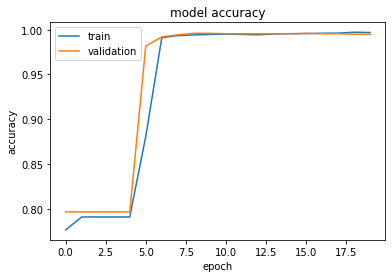

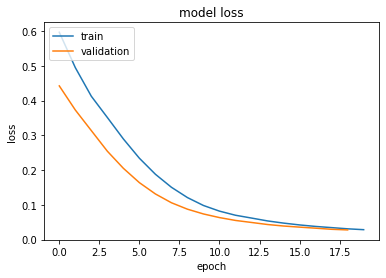

In [27]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'][1:43])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [28]:
#train
from sklearn.metrics import confusion_matrix

pred = model.predict(X_train)
y_pred = [0 if y[0]>.94 else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 0.976003
Precision: 0.970557
Recall: 1.000000
F1 score: 0.985059
Cohens kappa: 0.924214
ROC AUC: 0.942584
[[1295  168]
 [   0 5538]]


In [26]:
def Myextract_features(filePath, sampleRate=44100):
    
    signal,sr = librosa.load(filePath, sampleRate)

    #centroid = librosa.feature.spectral_centroid(y=signal,sr=sr)
    mfcc = librosa.feature.mfcc(y=signal, sr=sr)
    #features = librosa.feature.melspectrogram(y=signal,sr=sr, n_mels=1)
    mel = librosa.feature.melspectrogram(y=signal, sr=sr)

    features = np.concatenate((mel,mfcc),axis=0)

    return features

In [29]:
import pandas as pd

filenames = pd.read_csv('/Users/pooyan/Documents/CMMS/normal.csv')
#convert filenames from dataframe to array
filenames = np.array(filenames['name'].values)
#read all noraml files
parent_dir = '/Users/pooyan/Desktop/data_cmms/skytraina_06252019/turbo/'
sub_dir = 'combine/'
file_ext='*.ogg'
#all_Normalfiles = glob.glob(os.path.join(parent_dir, sub_dir, file_ext))[0:2500]
all_Normalfiles = parent_dir +sub_dir+ filenames


all_noraml_features = [] #define an empty array
all_noraml_labels = []
for i in range(0,len(all_Normalfiles)):
    my_features = Myextract_features(all_Normalfiles[i])
    all_noraml_features.append(my_features)
    all_noraml_labels.append("normal")

#use reshape to conver outputs into arrays
dim_1 = len(all_Normalfiles)
dim_2 = my_features.shape[0] #number of features
dim_3 = my_features.shape[1]
all_noraml_features = np.asarray(all_noraml_features).reshape(dim_1, dim_2, dim_3)
all_noraml_labels = np.asarray(all_noraml_labels).reshape(dim_1)

#check the dimentions
print(all_noraml_features.shape)
print(all_noraml_labels.shape)

#read all anoamly files
filenames = pd.read_csv('/Users/pooyan/Documents/CMMS/anomaly.csv')
#convert filenames from dataframe to array
filenames = np.array(filenames['name'].values)

parent_dir = '/Users/pooyan/Desktop/data_cmms/skytraina_06252019/turbo/'
sub_dir = 'combine/'
file_ext='*.ogg'
#all_Anomalyfiles = glob.glob(os.path.join(parent_dir, sub_dir, file_ext))[0:1000]
all_Anomalyfiles = parent_dir +sub_dir+ filenames

all_anomaly_features = [] #define an empty array
all_anomaly_labels = []
for i in range(0,len(all_Anomalyfiles)):
    my_features = Myextract_features(all_Anomalyfiles[i])
    all_anomaly_features.append(my_features)
    all_anomaly_labels.append("anomaly")

#use reshape to conver outputs into arrays
dim_1 = len(all_Anomalyfiles)
dim_2 = my_features.shape[0] #number of features
dim_3 = my_features.shape[1]
all_anomaly_features = np.asarray(all_anomaly_features).reshape(dim_1, dim_2, dim_3)
all_anomaly_labels = np.asarray(all_anomaly_labels).reshape(dim_1)

#check the dimentions
print(all_anomaly_features.shape)
print(all_anomaly_labels.shape)

#Merge noraml and anomaly arrays
all_data = np.concatenate((all_noraml_features,all_anomaly_features),axis=0)
all_label = np.concatenate((all_noraml_labels,all_anomaly_labels),axis=0)

#check the dimentions
print(all_data.shape)

(8633, 148, 259)
(8633,)
(2308, 148, 259)
(2308,)
(10941, 148, 259)


In [30]:
#endocding labels
my_ec = LabelEncoder()
all_label = my_ec.fit_transform(all_label)

my_ec.transform(["normal"])
my_ec.inverse_transform(all_label)

#split data into train. validation, and test
X_train, X_test, y_train, y_test = train_test_split(all_data,all_label,test_size=0.2,shuffle=True)
X_train, X_validation, y_train, y_validation = train_test_split(X_train,y_train,test_size=0.2,shuffle=True)

#check the dimentions
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

#check the dimentions
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(7001, 148, 259)
(2189, 148, 259)
(1751, 148, 259)
(7001, 148, 259)
(2189, 148, 259)
(1751, 148, 259)


In [31]:
from keras import layers as keras_layers
import numpy as np    
from keras.layers.convolutional import Conv1D    
from keras.layers.convolutional import MaxPooling1D 

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(148,259)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 146, 64)           49792     
                                                                 
 conv1d_4 (Conv1D)           (None, 144, 64)           12352     
                                                                 
 dropout_3 (Dropout)         (None, 144, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 72, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense_6 (Dense)             (None, 100)               460900    
                                                      

In [32]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
history=model.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 20, batch_size = 128, verbose = 1)


Epoch 1/20
55/55 [==============================] - 5s 78ms/step - loss: 18.9985 - accuracy: 0.9123 - val_loss: 3.2662 - val_accuracy: 0.9874
Epoch 2/20
55/55 [==============================] - 4s 70ms/step - loss: 3.0656 - accuracy: 0.9837 - val_loss: 1.1872 - val_accuracy: 0.9931
Epoch 3/20
55/55 [==============================] - 4s 71ms/step - loss: 1.5501 - accuracy: 0.9900 - val_loss: 0.8741 - val_accuracy: 0.9943
Epoch 4/20
55/55 [==============================] - 4s 72ms/step - loss: 1.0905 - accuracy: 0.9923 - val_loss: 0.9055 - val_accuracy: 0.9937
Epoch 5/20
55/55 [==============================] - 4s 72ms/step - loss: 1.3424 - accuracy: 0.9899 - val_loss: 0.6585 - val_accuracy: 0.9949
Epoch 6/20
55/55 [==============================] - 4s 70ms/step - loss: 0.8277 - accuracy: 0.9926 - val_loss: 0.6977 - val_accuracy: 0.9943
Epoch 7/20
55/55 [==============================] - 4s 71ms/step - loss: 0.7527 - accuracy: 0.9934 - val_loss: 0.3379 - val_accuracy: 0.9954
Epoch 8/20
5

In [33]:
#train
from sklearn.metrics import confusion_matrix

pred = model.predict(X_train)
y_pred = [0 if y[0]>.94 else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 0.999429
Precision: 1.000000
Recall: 0.999275
F1 score: 0.999637
Cohens kappa: 0.998291
ROC AUC: 0.999638
[[1483    0]
 [   4 5514]]


In [34]:
#test
pred = model.predict(X_test)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.998173
Precision: 0.999421
Recall: 0.998265
F1 score: 0.998843
Cohens kappa: 0.994504
ROC AUC: 0.998045
[[ 459    1]
 [   3 1726]]


In [35]:
from keras import layers as keras_layers
import numpy as np    
from keras.layers.convolutional import Conv1D    
from keras.layers.convolutional import MaxPooling1D 

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(148,259)))
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 146, 64)           49792     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 73, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 4672)              0         
                                                                 
 dense_8 (Dense)             (None, 100)               467300    
                                                                 
 dense_9 (Dense)             (None, 2)                 202       
                                                                 
Total params: 517,294
Trainable params: 517,294
Non-trainable params: 0
________________________________________________

In [36]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
history=model.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 20, batch_size = 128, verbose = 1)


Epoch 1/20
55/55 [==============================] - 3s 56ms/step - loss: 11.4383 - accuracy: 0.9571 - val_loss: 1.8382 - val_accuracy: 0.9914
Epoch 2/20
55/55 [==============================] - 3s 53ms/step - loss: 1.3939 - accuracy: 0.9924 - val_loss: 1.0348 - val_accuracy: 0.9949
Epoch 3/20
55/55 [==============================] - 3s 53ms/step - loss: 0.6636 - accuracy: 0.9957 - val_loss: 1.2406 - val_accuracy: 0.9931
Epoch 4/20
55/55 [==============================] - 3s 54ms/step - loss: 0.5978 - accuracy: 0.9959 - val_loss: 0.9043 - val_accuracy: 0.9931
Epoch 5/20
55/55 [==============================] - 3s 53ms/step - loss: 0.2087 - accuracy: 0.9969 - val_loss: 0.9062 - val_accuracy: 0.9937
Epoch 6/20
55/55 [==============================] - 3s 53ms/step - loss: 0.0908 - accuracy: 0.9989 - val_loss: 0.7233 - val_accuracy: 0.9949
Epoch 7/20
55/55 [==============================] - 3s 53ms/step - loss: 0.0219 - accuracy: 0.9991 - val_loss: 0.8298 - val_accuracy: 0.9949
Epoch 8/20
5

In [37]:
#train
from sklearn.metrics import confusion_matrix

pred = model.predict(X_train)
y_pred = [0 if y[0]>.94 else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 0.989002
Precision: 0.997440
Recall: 0.988583
F1 score: 0.992992
Cohens kappa: 0.967455
ROC AUC: 0.989571
[[1469   14]
 [  63 5455]]


In [38]:
#test
pred = model.predict(X_test)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.989493
Precision: 0.987429
Recall: 0.999422
F1 score: 0.993389
Cohens kappa: 0.967809
ROC AUC: 0.975798
[[ 438   22]
 [   1 1728]]


In [55]:
#new features

def Myextract_features(filePath, sampleRate=44100):
    
    signal,sr = librosa.load(filePath, sampleRate)

    centroid = librosa.feature.spectral_centroid(y=signal,sr=sr)
    #mfcc = librosa.feature.mfcc(y=signal, sr=sr)
    #features = librosa.feature.melspectrogram(y=signal,sr=sr, n_mels=1)
    slope = librosa.feature.melspectrogram(y=signal, sr=sr)

    #features = np.concatenate((mel,mfcc),axis=0)
    features = np.concatenate((centroid,slope),axis=0)
    
    return features

In [56]:
import pandas as pd

filenames = pd.read_csv('/Users/pooyan/Documents/CMMS/normal.csv')
#convert filenames from dataframe to array
filenames = np.array(filenames['name'].values)
#read all noraml files
parent_dir = '/Users/pooyan/Desktop/data_cmms/skytraina_06252019/turbo/'
sub_dir = 'combine/'
file_ext='*.ogg'
#all_Normalfiles = glob.glob(os.path.join(parent_dir, sub_dir, file_ext))[0:2500]
all_Normalfiles = parent_dir +sub_dir+ filenames


all_noraml_features = [] #define an empty array
all_noraml_labels = []
for i in range(0,len(all_Normalfiles)):
    my_features = Myextract_features(all_Normalfiles[i])
    all_noraml_features.append(my_features)
    all_noraml_labels.append("normal")

#use reshape to conver outputs into arrays
dim_1 = len(all_Normalfiles)
dim_2 = my_features.shape[0] #number of features
dim_3 = my_features.shape[1]
all_noraml_features = np.asarray(all_noraml_features).reshape(dim_1, dim_2, dim_3)
all_noraml_labels = np.asarray(all_noraml_labels).reshape(dim_1)

#check the dimentions
print(all_noraml_features.shape)
print(all_noraml_labels.shape)

#read all anoamly files
filenames = pd.read_csv('/Users/pooyan/Documents/CMMS/anomaly.csv')
#convert filenames from dataframe to array
filenames = np.array(filenames['name'].values)

parent_dir = '/Users/pooyan/Desktop/data_cmms/skytraina_06252019/turbo/'
sub_dir = 'combine/'
file_ext='*.ogg'
#all_Anomalyfiles = glob.glob(os.path.join(parent_dir, sub_dir, file_ext))[0:1000]
all_Anomalyfiles = parent_dir +sub_dir+ filenames

all_anomaly_features = [] #define an empty array
all_anomaly_labels = []
for i in range(0,len(all_Anomalyfiles)):
    my_features = Myextract_features(all_Anomalyfiles[i])
    all_anomaly_features.append(my_features)
    all_anomaly_labels.append("anomaly")

#use reshape to conver outputs into arrays
dim_1 = len(all_Anomalyfiles)
dim_2 = my_features.shape[0] #number of features
dim_3 = my_features.shape[1]
all_anomaly_features = np.asarray(all_anomaly_features).reshape(dim_1, dim_2, dim_3)
all_anomaly_labels = np.asarray(all_anomaly_labels).reshape(dim_1)

#check the dimentions
print(all_anomaly_features.shape)
print(all_anomaly_labels.shape)

#Merge noraml and anomaly arrays
all_data = np.concatenate((all_noraml_features,all_anomaly_features),axis=0)
all_label = np.concatenate((all_noraml_labels,all_anomaly_labels),axis=0)

#check the dimentions
print(all_data.shape)

(8633, 129, 259)
(8633,)
(2308, 129, 259)
(2308,)
(10941, 129, 259)


In [57]:
#endocding labels
my_ec = LabelEncoder()
all_label = my_ec.fit_transform(all_label)

my_ec.transform(["normal"])
my_ec.inverse_transform(all_label)

#split data into train. validation, and test
X_train, X_test, y_train, y_test = train_test_split(all_data,all_label,test_size=0.2,shuffle=True)
X_train, X_validation, y_train, y_validation = train_test_split(X_train,y_train,test_size=0.2,shuffle=True)

#check the dimentions
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

#check the dimentions
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(7001, 129, 259)
(2189, 129, 259)
(1751, 129, 259)
(7001, 129, 259)
(2189, 129, 259)
(1751, 129, 259)


In [58]:
from keras import layers as keras_layers
import numpy as np    
from keras.layers.convolutional import Conv1D    
from keras.layers.convolutional import MaxPooling1D 

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(129,259)))
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 127, 64)           49792     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 63, 64)           0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 4032)              0         
                                                                 
 dense_16 (Dense)            (None, 50)                201650    
                                                                 
 dense_17 (Dense)            (None, 2)                 102       
                                                                 
Total params: 251,544
Trainable params: 251,544
Non-trainable params: 0
_______________________________________________

In [59]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
history=model.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 20, batch_size = 128, verbose = 1)


Epoch 1/20
55/55 [==============================] - 3s 48ms/step - loss: 34.4636 - accuracy: 0.8977 - val_loss: 4.2443 - val_accuracy: 0.9834
Epoch 2/20
55/55 [==============================] - 2s 43ms/step - loss: 3.3589 - accuracy: 0.9847 - val_loss: 3.2194 - val_accuracy: 0.9817
Epoch 3/20
55/55 [==============================] - 2s 44ms/step - loss: 1.9206 - accuracy: 0.9879 - val_loss: 2.3784 - val_accuracy: 0.9857
Epoch 4/20
55/55 [==============================] - 2s 44ms/step - loss: 1.5608 - accuracy: 0.9899 - val_loss: 1.9516 - val_accuracy: 0.9874
Epoch 5/20
55/55 [==============================] - 2s 42ms/step - loss: 1.0749 - accuracy: 0.9914 - val_loss: 1.8200 - val_accuracy: 0.9863
Epoch 6/20
55/55 [==============================] - 2s 43ms/step - loss: 0.7307 - accuracy: 0.9927 - val_loss: 1.6348 - val_accuracy: 0.9891
Epoch 7/20
55/55 [==============================] - 2s 44ms/step - loss: 0.6061 - accuracy: 0.9930 - val_loss: 2.0361 - val_accuracy: 0.9863
Epoch 8/20
5

In [60]:
#train
from sklearn.metrics import confusion_matrix

pred = model.predict(X_train)
y_pred = [0 if y[0]>y[1]  else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 0.968290
Precision: 0.961371
Recall: 1.000000
F1 score: 0.980305
Cohens kappa: 0.899148
ROC AUC: 0.924797
[[1254  222]
 [   0 5525]]


In [61]:
#test
pred = model.predict(X_test)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.961626
Precision: 0.953540
Recall: 1.000000
F1 score: 0.976217
Cohens kappa: 0.877217
ROC AUC: 0.909677
[[ 381   84]
 [   0 1724]]


In [116]:
model5 = Sequential()
model5.add(Conv1D(10, kernel_size=3, activation = 'relu', input_shape=(129,259)))
#model.add(LSTM(10, return_sequences=True))
#model.add(Conv1D(10, kernel_size=3, activation = 'relu'))
#model.add(Dropout(rate=0.2))
model5.add(LSTM(10))
#model.add(Dropout(rate=0.2))
model5.add(Dense(10))
#model.add(Dropout(rate=0.2))
model5.add(Dense(2, activation='sigmoid'))
model5.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_29 (Conv1D)          (None, 127, 10)           7780      
                                                                 
 lstm_24 (LSTM)              (None, 10)                840       
                                                                 
 dense_44 (Dense)            (None, 10)                110       
                                                                 
 dense_45 (Dense)            (None, 2)                 22        
                                                                 
Total params: 8,752
Trainable params: 8,752
Non-trainable params: 0
_________________________________________________________________


In [117]:
model5.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
history=model5.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 10, batch_size = 128, verbose = 1)


Epoch 1/10
55/55 [==============================] - 6s 78ms/step - loss: 0.6274 - accuracy: 0.7182 - val_loss: 0.5369 - val_accuracy: 0.7904
Epoch 2/10
55/55 [==============================] - 3s 50ms/step - loss: 0.4479 - accuracy: 0.7892 - val_loss: 0.3689 - val_accuracy: 0.7904
Epoch 3/10
55/55 [==============================] - 3s 49ms/step - loss: 0.3283 - accuracy: 0.7892 - val_loss: 0.2935 - val_accuracy: 0.7904
Epoch 4/10
55/55 [==============================] - 3s 49ms/step - loss: 0.2714 - accuracy: 0.7892 - val_loss: 0.2466 - val_accuracy: 0.7904
Epoch 5/10
55/55 [==============================] - 3s 49ms/step - loss: 0.2297 - accuracy: 0.7892 - val_loss: 0.2123 - val_accuracy: 0.7904
Epoch 6/10
55/55 [==============================] - 3s 49ms/step - loss: 0.2005 - accuracy: 0.9259 - val_loss: 0.1861 - val_accuracy: 0.9954
Epoch 7/10
55/55 [==============================] - 3s 52ms/step - loss: 0.1754 - accuracy: 0.9950 - val_loss: 0.1620 - val_accuracy: 0.9960
Epoch 8/10
55

In [114]:
#train
from sklearn.metrics import confusion_matrix

pred = model4.predict(X_train)
y_pred = [0 if y[0]>.95  else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 0.789173
Precision: 0.789173
Recall: 1.000000
F1 score: 0.882165
Cohens kappa: 0.000000
ROC AUC: 0.500000
[[   0 1476]
 [   0 5525]]


In [115]:
#test
pred = model.predict(X_test)
y_pred = [0 if y[0]>0.95 else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.787574
Precision: 0.787574
Recall: 1.000000
F1 score: 0.881165
Cohens kappa: 0.000000
ROC AUC: 0.500000
[[   0  465]
 [   0 1724]]


In [105]:
model = tf.keras.Sequential()
model.add(LSTM(50, input_shape=(129,259)))
#model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(2,activation = 'softmax'))
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 50)                62000     
                                                                 
 dense_42 (Dense)            (None, 64)                3264      
                                                                 
 dense_43 (Dense)            (None, 2)                 130       
                                                                 
Total params: 65,394
Trainable params: 65,394
Non-trainable params: 0
_________________________________________________________________


In [106]:
model4.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
history=model4.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 20, batch_size = 128, verbose = 1)


Epoch 1/20
55/55 [==============================] - 8s 83ms/step - loss: 0.1225 - accuracy: 0.9953 - val_loss: 0.1089 - val_accuracy: 0.9966
Epoch 2/20
55/55 [==============================] - 3s 48ms/step - loss: 0.1012 - accuracy: 0.9953 - val_loss: 0.0887 - val_accuracy: 0.9971
Epoch 3/20
55/55 [==============================] - 3s 47ms/step - loss: 0.0828 - accuracy: 0.9951 - val_loss: 0.0716 - val_accuracy: 0.9966
Epoch 4/20
55/55 [==============================] - 3s 49ms/step - loss: 0.0669 - accuracy: 0.9951 - val_loss: 0.0573 - val_accuracy: 0.9971
Epoch 5/20
55/55 [==============================] - 3s 48ms/step - loss: 0.0549 - accuracy: 0.9947 - val_loss: 0.0463 - val_accuracy: 0.9966
Epoch 6/20
55/55 [==============================] - 3s 46ms/step - loss: 0.0443 - accuracy: 0.9951 - val_loss: 0.0394 - val_accuracy: 0.9966
Epoch 7/20
55/55 [==============================] - 3s 47ms/step - loss: 0.0380 - accuracy: 0.9951 - val_loss: 0.0308 - val_accuracy: 0.9971
Epoch 8/20
55

In [108]:
#train
from sklearn.metrics import confusion_matrix

pred = model4.predict(X_train)
y_pred = [0 if y[0]>.70   else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 0.995001
Precision: 0.994060
Recall: 0.999638
F1 score: 0.996841
Cohens kappa: 0.984860
ROC AUC: 0.988640
[[1443   33]
 [   2 5523]]
